# Framework

In [1]:
import pickle
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt

from bikewaysim.paths import config
from bikewaysim.framework import bikewaysim_functions
from bikewaysim.impedance_calibration import stochastic_optimization
from bikewaysim.network import modeling_turns
from bikewaysim.routing import rustworkx_routing_funcs

## ODS

In [2]:
# import matched ODS (i.e. already have the correct network nodes)
od_matrix = pd.read_csv(config['bikewaysim_fp']/'od_matrix.csv')
ods = list(set(zip(od_matrix['orig_N'],od_matrix['dest_N'])))

# Network Import

Merge the three network together

In [3]:
_, _, length_dict, geo_dict, _ = rustworkx_routing_funcs.import_calibration_network(config)

cols_to_keep = ['linkid','reverse_link','travel_time_min','multiplier','link_cost']

current_links = gpd.read_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='current_network').loc[:,cols_to_keep+['geometry']].set_index(['linkid','reverse_link'])
future_links = gpd.read_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='future_network').loc[:,cols_to_keep+['geometry']].set_index(['linkid','reverse_link'])
current_links.columns = 'current_' + current_links.columns
future_links.columns = 'future_' + future_links.columns

links = pd.concat([current_links,future_links],ignore_index=False,axis=1)

merge_these_cols = ['travel_time_min','geometry']

for col in merge_these_cols:
    links[col] = links[f'current_{col}'].fillna(links[f'future_{col}'])
    links.drop(columns=[f'current_{col}',f'future_{col}'],inplace=True)

links.set_geometry('geometry',inplace=True)
links.reset_index(inplace=True)

26 unique projects


<Axes: >

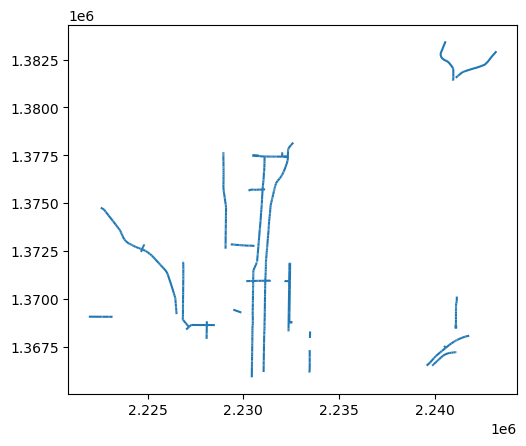

In [4]:
improvements = gpd.read_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='improvements')
print(improvements[f"{config['mod_name']}_id"].nunique(),'unique projects')
improvements[improvements[f"{config['mod_name']}_id"].notna()].plot()

# Get link impedance reduction from improvements

Get base link impedance reduction

In [5]:
# NOTE: we want these to only be negative or zero
links['impedance_reduction'] = links['future_multiplier'] - links['current_multiplier']
links['impedance_reduction'].describe()

count    24116.000000
mean        -0.028672
std          0.116938
min         -0.511500
25%          0.000000
50%          0.000000
75%          0.000000
max          0.000000
Name: impedance_reduction, dtype: float64

In [6]:
max_impedance_reduction = links[links['impedance_reduction']<0].groupby('linkid')['impedance_reduction'].idxmin()
link_impedance_reduction = links.loc[max_impedance_reduction]
link_impedance_reduction['impedance_reduction_display'] = (link_impedance_reduction['impedance_reduction'].abs() * 100).astype(int)
link_impedance_reduction.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='link_impedance_reduction')

In [7]:
undirected_links = links[links['reverse_link']==False]

# Import Routing Results

In [8]:
# with (config['bikewaysim_fp']/"current_shortest_results.pkl").open('rb') as fh:
#     shortest_results_dict = pickle.load(fh)

# with (config['bikewaysim_fp']/"current_results.pkl").open('rb') as fh:
#     current_results_dict = pickle.load(fh)

# with (config['bikewaysim_fp']/"future_results.pkl").open('rb') as fh:
#     future_results_dict = pickle.load(fh)

with (config['bikewaysim_fp']/'parallel_routing.pkl').open('rb') as fh:
    routing_results = pickle.load(fh)

In [9]:
from collections import defaultdict
routing_results_dict = defaultdict(dict)
for name, result in routing_results:
    routing_results_dict[name].update(result)

In [10]:
shortest_results_dict = routing_results_dict['current_traveltime']
current_results_dict = routing_results_dict['current_impedance']
future_results_dict = routing_results_dict['future_impedance']

# Weighted Impedance Change for trips

In [11]:
from importlib import reload
reload(bikewaysim_functions)

<module 'bikewaysim.framework.bikewaysim_functions' from '/Users/tannerpassmore/Documents/GitHub/BikewaySimDev/src/bikewaysim/framework/bikewaysim_functions.py'>

In [12]:
travel_time_dict = dict(zip(links['linkid'],links['travel_time_min']))
bikewaysim_functions.weighted_impedance_reduction(od_matrix,travel_time_dict,current_results_dict,future_results_dict,shortest_results_dict)

The weighted average reduction in impedance was 0.42 minutes
The impedance for 212 OD pairs did not decrease
The max reduction in impedance was 3.57 minutes


,dest_taz,orig_taz,trips,orig_N,dest_N,current_tt_min,future_tt_min,shortest_tt_min,current_impedance,future_impedance,impedance_reduction
0,130890202002005,130890202002005,1,7.320658e+09,7.320658e+09,NaN,NaN,NaN,NaN,NaN,NaN
1,130890202002005,130890224011011,1,6.877187e+09,7.320658e+09,5.048556,5.048556,5.048556,7.241774,7.241774,0.000000
2,130890202002005,131210029001021,1,7.468310e+09,7.320658e+09,16.752370,16.752370,15.484074,14.866534,14.866534,0.000000
3,130890202002005,131210030002002,1,6.927455e+07,7.320658e+09,12.421979,12.421979,11.344892,13.818441,13.818441,0.000000
4,130890202002007,130890202002011,1,5.422171e+09,6.819200e+07,2.769204,2.769204,2.769204,4.286158,4.286158,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
458,131210035002001,131210021001002,1,6.008664e+09,3.172082e+09,6.664359,6.664359,5.777056,10.753641,10.657555,0.096086
459,131210035002001,131210021001010,2,1.287599e+10,3.172082e+09,5.460194,5.460194,5.296315,9.746357,9.650271,0.096086
460,131210035002003,131210030002002,1,6.927455e+07,6.934994e+07,15.119006,15.119006,14.376124,19.423865,19.423865,0.000000
461,131210035002004,131210021001000,1,6.931249e+07,1.130069e+10,6.523858,5.115548,5.115548,10.899015,10.695069,0.203946


## Weighted Impedance Reduction Per TAZ

In [13]:
# trip_impedance_reduction = od_matrix.groupby('orig_taz').apply(lambda x: ((x['current_impedance']-x['future_impedance']) * x['trips']).sum() )
# #studyarea = gpd.read_file(config['studyarea_fp'])
# #tazs = gpd.read_file(config['bikewaysim_fp']/'ods.gpkg',layer='trip_origins')#,mask=studyarea)
# tazs = gpd.read_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='taz_polygons')#,mask=studyarea)
# tazs['impedance_change'] = tazs['tazid'].map(trip_impedance_reduction) / 1000
# tazs.explore('impedance_change')

<Axes: >

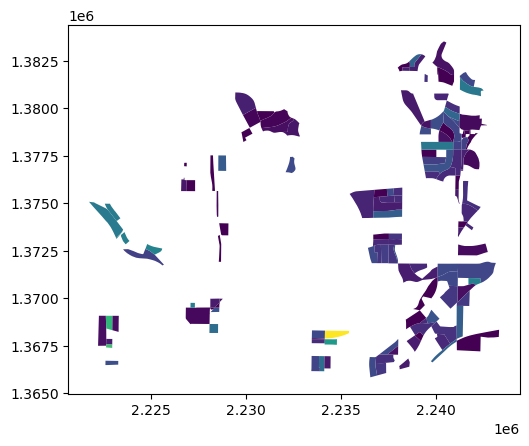

In [14]:
trip_impedance_reduction = od_matrix.groupby('orig_taz').apply(lambda x: ((x['current_impedance']-x['future_impedance']) * x['trips']).sum() / x['trips'].sum())
#studyarea = gpd.read_file(config['studyarea_fp'])
#tazs = gpd.read_file(config['bikewaysim_fp']/'ods.gpkg',layer='trip_origins')#,mask=studyarea)
tazs = gpd.read_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='taz_polygons')#,mask=studyarea)
tazs['impedance_change'] = tazs['tazid'].map(trip_impedance_reduction)
tazs.plot('impedance_change')

In [15]:
tazs['impedance_change'].isna().sum()

np.int64(0)

In [16]:
print(tazs[tazs['impedance_change']==0].shape[0],'TAZs had zero change in impedance')

23 TAZs had zero change in impedance


In [17]:
tazs[tazs['impedance_change']==0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='origin_weighted_impedance_nochange')
tazs[tazs['impedance_change']>0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='origin_weighted_impedance_change')

# Percent Detour

In [18]:
# od_matrix['detour'] = od_matrix['current_tt_min'] - od_matrix['shortest_tt_min']
# detour = od_matrix.groupby('orig_taz').apply(lambda x: (x.detour * x.trips).sum() / x.trips.sum())
# #od_matrix.hist(od_matrix['detour'],bins=50,weights=od_matrix['trips'])
# tazs['detour'] = tazs['tazid'].map(detour)
# tazs.plot('detour')

In [19]:
od_matrix['percent_detour'] = ((od_matrix['current_tt_min'] - od_matrix['shortest_tt_min']) / od_matrix['shortest_tt_min'] * 100)#.round(1)
od_matrix['percent_detour'].describe()

count    456.000000
mean      12.268077
std       15.245150
min        0.000000
25%        1.705302
50%        7.537611
75%       16.209021
max      129.584067
Name: percent_detour, dtype: float64

In [20]:
od_matrix['percent_detour'].median()

np.float64(7.5376105172608305)

In [21]:
x, y = od_matrix.loc[od_matrix['percent_detour'].idxmax()][['orig_N','dest_N']].values

In [22]:
# for inspecting trips
gpd.GeoDataFrame(
    {'geometry':[geo_dict[x[0]] for x in current_results_dict[(x,y)]['edge_list']]},
    crs=config['projected_crs_epsg']
).explore()

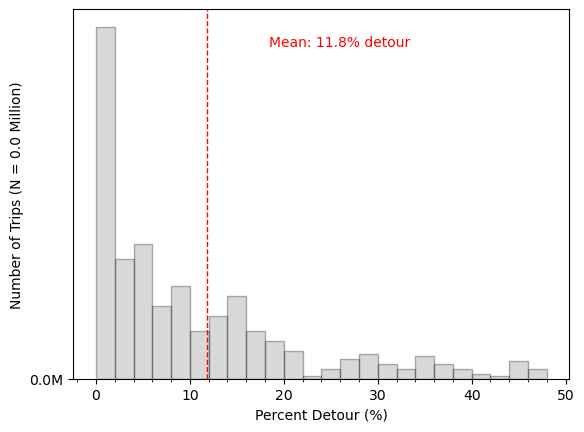

In [23]:
from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)

# plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots()
ax.hist(od_matrix['percent_detour'], bins=range(0, 50, 2), alpha=0.3, color='grey', weights=od_matrix['trips'],edgecolor='black')
ax.set_xlabel(f"Percent Detour (%)")
ax.set_ylabel(f"Number of Trips (N = {od_matrix['trips'].sum() / 10**6 :.1f} Million)")

mean_percent_detour = (od_matrix['percent_detour'] * od_matrix['trips']).sum() / od_matrix['trips'].sum()
ax.axvline(mean_percent_detour, color='red', linestyle='dashed', linewidth=1)
ax.text(od_matrix['percent_detour'].mean() * 1.5, plt.gca().get_ylim()[1] * 0.9, f"Mean: {mean_percent_detour:,.1f}% detour", color='red', ha='left')

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(0.5*10**6))
ax.yaxis.set_minor_locator(MultipleLocator(0.1*10**6))
ax.yaxis.set_major_formatter(formatter)

plt.savefig(config['figures_fp']/'percent_detour.png',dpi=300)
plt.show()

In [24]:
percent_detour = od_matrix.groupby('orig_taz').apply(lambda x: (x.percent_detour * x.trips).sum() / x.trips.sum())
percent_detour.describe()

count    132.000000
mean      11.355079
std        9.195011
min        0.000000
25%        3.613761
50%        9.824820
75%       16.519580
max       45.886705
dtype: float64

<Axes: >

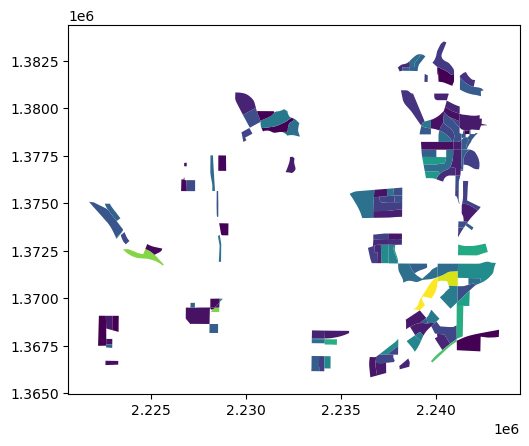

In [25]:
# tazs = gpd.read_file(config['bikewaysim_fp']/'ods.gpkg',layer='trip_origins')
tazs = gpd.read_file(config['bikewaysim_fp']/'map_layers.gpkg',layer='taz_polygons')#,mask=studyarea)
tazs['percent_detour'] = tazs['tazid'].map(percent_detour)
tazs.plot('percent_detour')

In [26]:
tazs.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='percent_detour')

## Percent Detour Change Due to Network Improvements (future)

In [27]:
od_matrix['improved_percent_detour'] = ((od_matrix['future_tt_min'] - od_matrix['shortest_tt_min']) / od_matrix['shortest_tt_min'] * 100)#.round(1)
improved_percent_detour = od_matrix.groupby('orig_taz').apply(lambda x: (x.improved_percent_detour * x.trips).sum() / x.trips.sum())
improved_percent_detour.describe()

count    132.000000
mean      11.753595
std       10.501220
min        0.000000
25%        4.295055
50%        9.608619
75%       16.886420
max       64.508895
dtype: float64

In [28]:
# tazs['improved_percent_detour'] = tazs['tazid'].map(improved_percent_detour)
# tazs['percent_detour_change'] = tazs['improved_percent_detour'] - tazs['percent_detour']
# tazs['percent_detour_change'].hist()

In [29]:
# tazs.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='percent_detour')

# Link Betweenness Centrality (LBC)
We need this to visualize how trips shifted and to detemrine the impedance reduction contribution of each project.

In [30]:
#directed is number of trips by direction, undirected is combined number of trips
shortest_undirected_btw_centrality = {key:0 for key in links['linkid'].tolist()}
shortest_directed_btw_centrality = {key:0 for key in list(zip(links['linkid'],links['reverse_link']))}
current_undirected_btw_centrality = {key:0 for key in links['linkid'].tolist()}
current_directed_btw_centrality = {key:0 for key in list(zip(links['linkid'],links['reverse_link']))}
future_undirected_btw_centrality = {key:0 for key in links['linkid'].tolist()}
future_directed_btw_centrality = {key:0 for key in list(zip(links['linkid'],links['reverse_link']))}

dict_keys = list(set.union(set(current_results_dict.keys()),set(future_results_dict.keys())))
for od_pair in dict_keys:
    #get number of trips for that origin node and destinnation node
    o_check = od_matrix['orig_N']==od_pair[0]
    d_check = od_matrix['dest_N']==od_pair[1]
    num_trips = od_matrix.loc[o_check & d_check,'trips'].sum()
    
    #retreive the edge list
    shortest_modeled_edges = shortest_results_dict.get(od_pair,0)
    current_modeled_edges = current_results_dict.get(od_pair,0)
    future_modeled_edges = future_results_dict.get(od_pair,0)
    
    #current
    if shortest_modeled_edges != 0:
        #retrieve the edge list
        shortest_modeled_edges = [tuple(x) for x in shortest_modeled_edges['edge_list']]
        #now add the num trips for each edge in the edge list
        for edge in shortest_modeled_edges:
            shortest_directed_btw_centrality[edge] += num_trips
            shortest_undirected_btw_centrality[edge[0]] += num_trips

    #current
    if current_modeled_edges != 0:
        #retrieve the edge list
        current_modeled_edges = [tuple(x) for x in current_modeled_edges['edge_list']]
        #now add the num trips for each edge in the edge list
        for edge in current_modeled_edges:
            current_directed_btw_centrality[edge] += num_trips
            current_undirected_btw_centrality[edge[0]] += num_trips
    #future
    if future_modeled_edges != 0:
        #retrieve the edge list
        future_modeled_edges = [tuple(x) for x in future_modeled_edges['edge_list']]
        #now add the num trips for each edge in the edge list
        for edge in future_modeled_edges:
            future_directed_btw_centrality[edge] += num_trips
            future_undirected_btw_centrality[edge[0]] += num_trips

#only keep non_zero entries
shortest_undirected_btw_centrality = {key:item for key,item in shortest_undirected_btw_centrality.items() if item > 0}
shortest_directed_btw_centrality = {key:item for key,item in shortest_directed_btw_centrality.items() if item > 0}
current_undirected_btw_centrality = {key:item for key,item in current_undirected_btw_centrality.items() if item > 0}
current_directed_btw_centrality = {key:item for key,item in current_directed_btw_centrality.items() if item > 0}
future_undirected_btw_centrality = {key:item for key,item in future_undirected_btw_centrality.items() if item > 0}
future_directed_btw_centrality = {key:item for key,item in future_directed_btw_centrality.items() if item > 0}            

#turn to dataframe
# directed btw centrality useful for directed bike facilities
df0 = pd.DataFrame.from_dict(shortest_directed_btw_centrality,orient='index',columns=['shortest_btw_centrality'])
df1 = pd.DataFrame.from_dict(current_directed_btw_centrality,orient='index',columns=['current_btw_centrality'])
df2 = pd.DataFrame.from_dict(future_directed_btw_centrality,orient='index',columns=['future_btw_centrality'])
directed_btw_centrality = pd.concat([df0,df1,df2],ignore_index=False,axis=1)
directed_btw_centrality.fillna(0,inplace=True)

df0 = pd.DataFrame.from_dict(shortest_undirected_btw_centrality,orient='index',columns=['shortest_btw_centrality'])
df1 = pd.DataFrame.from_dict(current_undirected_btw_centrality,orient='index',columns=['current_btw_centrality'])
df2 = pd.DataFrame.from_dict(future_undirected_btw_centrality,orient='index',columns=['future_btw_centrality'])
undirected_btw_centrality = pd.concat([df0,df1,df2],ignore_index=False,axis=1)
undirected_btw_centrality.fillna(0,inplace=True)
undirected_btw_centrality.reset_index(inplace=True)
undirected_btw_centrality.rename(columns={'index':'linkid'},inplace=True)

#calculate the change
directed_btw_centrality['impedance_change'] = directed_btw_centrality['current_btw_centrality'] - directed_btw_centrality['shortest_btw_centrality']
undirected_btw_centrality['impedance_change'] = undirected_btw_centrality['current_btw_centrality'] - undirected_btw_centrality['shortest_btw_centrality']

directed_btw_centrality['improvement_change'] = directed_btw_centrality['future_btw_centrality'] - directed_btw_centrality['current_btw_centrality']
undirected_btw_centrality['improvement_change'] = undirected_btw_centrality['future_btw_centrality'] - undirected_btw_centrality['current_btw_centrality']

#and pct change
#undirected_btw_centrality['pct_change'] = undirected_btw_centrality['change'] / undirected_btw_centrality['current_btw_centrality'] * 100


In [31]:
#add geometry data
undirected_btw_centrality_gdf = pd.merge(undirected_btw_centrality,undirected_links,on='linkid')
undirected_btw_centrality_gdf = gpd.GeoDataFrame(undirected_btw_centrality_gdf,geometry='geometry',crs=config['projected_crs_epsg'])

Plot change in LBC going from minimum travel time LBC to impedance LBC (both on current network)

<Axes: >

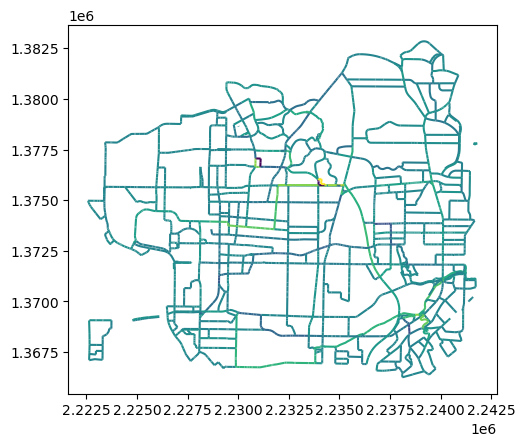

In [32]:
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['impedance_change']!=0].plot('impedance_change')

Plot change in LBC going from impednace LBC on current network to impedance LBC on future network

<Axes: >

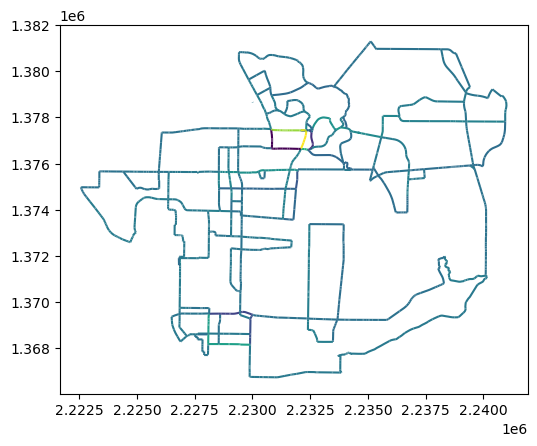

In [33]:
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['improvement_change']!=0].plot('improvement_change')

In [34]:
undirected_btw_centrality_gdf.describe()

,linkid,shortest_btw_centrality,current_btw_centrality,future_btw_centrality,impedance_change,improvement_change,current_multiplier,current_link_cost,future_multiplier,future_link_cost,travel_time_min,impedance_reduction
count,5209.000000,5209.000000,5209.000000,5209.000000,5209.000000,5209.000000,5209.000000,5209.000000,5209.000000,5209.000000,5209.000000,5209.000000
mean,13937.656172,8.226915,8.602227,8.694759,0.375312,0.092532,0.233643,0.180658,0.196749,0.176086,0.148459,-0.036894
std,11415.289500,11.732111,15.120064,15.984359,13.662891,8.047232,0.502154,0.243844,0.496414,0.240886,0.186757,0.131369
min,0.000000,0.000000,0.000000,0.000000,-86.000000,-59.000000,-0.511500,0.003440,-0.511500,0.002976,0.003888,-0.511500
25%,2965.000000,1.000000,0.000000,0.000000,-4.000000,0.000000,0.000000,0.039147,0.000000,0.037876,0.035219,0.000000
50%,10706.000000,4.000000,3.000000,3.000000,-1.000000,0.000000,0.000000,0.088065,0.000000,0.084425,0.071572,0.000000
75%,23260.000000,10.000000,9.000000,9.000000,3.000000,0.000000,0.493500,0.231019,0.493500,0.223876,0.190767,0.000000
max,38712.000000,93.000000,157.000000,150.000000,97.000000,90.000000,3.032500,4.467334,2.661500,4.467334,1.857756,0.000000


Export GPKGs for visualization in QGIS

In [35]:
#travel time lbc
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['shortest_btw_centrality']!=0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='lbc_shortest')
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['current_btw_centrality']!=0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='lbc_current')
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['future_btw_centrality']!=0].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='lbc_future')

undirected_btw_centrality_gdf.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='lbc_impedance_change')
undirected_btw_centrality_gdf.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='lbc_improvement_change')

## Impedance Reduction Contribution 

### Multiply Link Impedance Reduction by Betweenness Centrality for the Improved Links

$ Z_{i}=\frac{\sum_{l_{a}}{d}}{3} $

In [36]:
undirected_btw_centrality_gdf['impedance_contribution'] = undirected_btw_centrality_gdf.length * undirected_btw_centrality_gdf['impedance_reduction'] * undirected_btw_centrality_gdf['future_btw_centrality']
#undirected_btw_centrality_gdf['length'] = undirected_btw_centrality_gdf.length

In [37]:
undirected_btw_centrality_gdf.columns

Index(['linkid', 'shortest_btw_centrality', 'current_btw_centrality',
       'future_btw_centrality', 'impedance_change', 'improvement_change',
       'reverse_link', 'current_multiplier', 'current_link_cost',
       'future_multiplier', 'future_link_cost', 'travel_time_min', 'geometry',
       'impedance_reduction', 'impedance_contribution'],
      dtype='object')

In [38]:
undirected_btw_centrality_gdf['impedance_contribution'].min()

np.float64(-18964.14970917558)

In [39]:
undirected_btw_centrality_gdf['impedance_contribution'].max()

np.float64(0.0)

In [40]:
import numpy as np
from sklearn import preprocessing

scale = undirected_btw_centrality_gdf['impedance_contribution'].values.reshape(-1,1)
min_max_scaler = preprocessing.MinMaxScaler()
scale = min_max_scaler.fit_transform(scale)
scale

array([[1.        ],
       [1.        ],
       [1.        ],
       ...,
       [0.96070297],
       [0.95009946],
       [0.94488108]], shape=(5209, 1))

In [41]:
# #bring in name
# facility_names = gpd.read_file(config['bicycle_facilities_fp']/'network_modifications.gpkg',layer=config['mod_name'],ignore_geometry=True)
# facility_names = facility_names[[config['mod_name']+'_id',config['mod_name']+'_name',config['mod_name']+'_facilitytype']]
# impedance_contribution.crs

In [42]:
#merge with df
impedance_contribution = pd.merge(undirected_btw_centrality_gdf,improvements.drop(columns=['geometry']),on='linkid')
impedance_contribution['Length (mi)'] = impedance_contribution.length / 5280
impedance_contribution = impedance_contribution[['geometry','impedance_contribution','coa_name', 'improvement','Length (mi)']]
impedance_contribution = impedance_contribution.dissolve(['coa_name','improvement'],aggfunc=[np.sum]).sort_values(('impedance_contribution', 'sum')).reset_index()
impedance_contribution.columns = ['Name','Facility Type','geometry','Impedance Contribution','Length (mi)']
impedance_contribution['Impedance Contribution per Mile'] = impedance_contribution['Impedance Contribution'] / impedance_contribution['Length (mi)']

In [43]:
impedance_contribution

,Name,Facility Type,geometry,Impedance Contribution,Length (mi),Impedance Contribution per Mile
0,14th St NE,cycletrack,"MULTILINESTRING ((2232032.389 1377434.596, 223...",-101829.026938,0.401421,-253671.530195
1,Piedmont Ave NE,cycletrack,"MULTILINESTRING ((2231431.837 1374907.992, 223...",-54373.773102,1.043246,-52119.775692
2,Marietta St NW,bike lane,"MULTILINESTRING ((2223552.462 1373597.091, 222...",-31083.599941,1.327876,-23408.513144
3,Spring St NW,cycletrack,"MULTILINESTRING ((2229073.205 1372777.619, 222...",-13464.682265,0.824414,-16332.436126
4,10th St NE,cycletrack,"MULTILINESTRING ((2230709.374 1375704.783, 223...",-11819.041901,0.166289,-71075.447658
5,Centennial Olympic Park Dr NW,cycletrack,"MULTILINESTRING ((2228084.854 1368165.89, 2228...",-11359.290039,0.173829,-65347.391633
6,Luckie St NW/Tech Pkwy NW,cycletrack,"MULTILINESTRING ((2226862.786 1371816.355, 222...",-10635.343206,0.666964,-15945.906662
7,Central Park Pl NE,bike lane,"MULTILINESTRING ((2232409.053 1369290.356, 223...",-7995.030701,0.614284,-13015.200000
8,Moreland Ave NE,bike lane,"MULTILINESTRING ((2241103.467 1368631.566, 224...",-5379.387621,0.329545,-16323.666202
9,Baker St NW,cycletrack,"MULTILINESTRING ((2228514.426 1368633.58, 2228...",-3011.434329,0.300852,-10009.700480


In [44]:
impedance_contribution.sort_values('Impedance Contribution per Mile',inplace=True)
impedance_contribution['Impedance Contribution per Mile'] = impedance_contribution['Impedance Contribution per Mile'].abs().round(2)
impedance_contribution['Impedance Contribution'] = impedance_contribution['Impedance Contribution'].abs().round(2)
impedance_contribution['Length (mi)'] = impedance_contribution['Length (mi)'].round(3)
impedance_contribution.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='impedance_contribution')

In [45]:
impedance_contribution

,Name,Facility Type,geometry,Impedance Contribution,Length (mi),Impedance Contribution per Mile
0,14th St NE,cycletrack,"MULTILINESTRING ((2232032.389 1377434.596, 223...",101829.03,0.401,253671.53
4,10th St NE,cycletrack,"MULTILINESTRING ((2230709.374 1375704.783, 223...",11819.04,0.166,71075.45
5,Centennial Olympic Park Dr NW,cycletrack,"MULTILINESTRING ((2228084.854 1368165.89, 2228...",11359.29,0.174,65347.39
1,Piedmont Ave NE,cycletrack,"MULTILINESTRING ((2231431.837 1374907.992, 223...",54373.77,1.043,52119.78
10,Means St NW,bike lane,"MULTILINESTRING ((2224808.012 1372805.639, 222...",2939.57,0.083,35586.09
2,Marietta St NW,bike lane,"MULTILINESTRING ((2223552.462 1373597.091, 222...",31083.60,1.328,23408.51
13,Jackson St NE,bike lane,"MULTILINESTRING ((2233480.019 1367963.218, 223...",1279.99,0.064,19990.82
3,Spring St NW,cycletrack,"MULTILINESTRING ((2229073.205 1372777.619, 222...",13464.68,0.824,16332.44
8,Moreland Ave NE,bike lane,"MULTILINESTRING ((2241103.467 1368631.566, 224...",5379.39,0.330,16323.67
6,Luckie St NW/Tech Pkwy NW,cycletrack,"MULTILINESTRING ((2226862.786 1371816.355, 222...",10635.34,0.667,15945.91


<Axes: >

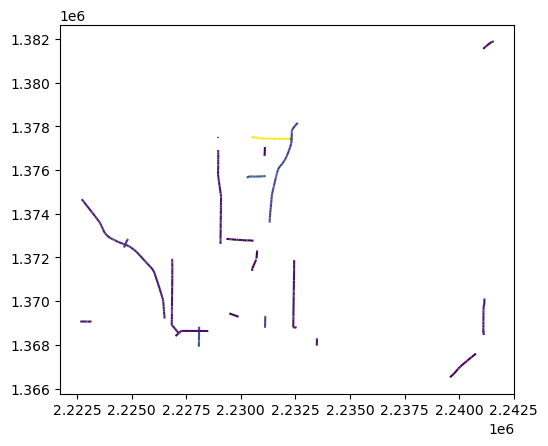

In [46]:
impedance_contribution.plot('Impedance Contribution per Mile')

Find top 10 facilities that are longer than 10 feet

In [47]:
top_ten = impedance_contribution#[impedance_contribution['Length (mi)']]
top_ten = top_ten.iloc[0:10]
top_ten

,Name,Facility Type,geometry,Impedance Contribution,Length (mi),Impedance Contribution per Mile
0,14th St NE,cycletrack,"MULTILINESTRING ((2232032.389 1377434.596, 223...",101829.03,0.401,253671.53
4,10th St NE,cycletrack,"MULTILINESTRING ((2230709.374 1375704.783, 223...",11819.04,0.166,71075.45
5,Centennial Olympic Park Dr NW,cycletrack,"MULTILINESTRING ((2228084.854 1368165.89, 2228...",11359.29,0.174,65347.39
1,Piedmont Ave NE,cycletrack,"MULTILINESTRING ((2231431.837 1374907.992, 223...",54373.77,1.043,52119.78
10,Means St NW,bike lane,"MULTILINESTRING ((2224808.012 1372805.639, 222...",2939.57,0.083,35586.09
2,Marietta St NW,bike lane,"MULTILINESTRING ((2223552.462 1373597.091, 222...",31083.60,1.328,23408.51
13,Jackson St NE,bike lane,"MULTILINESTRING ((2233480.019 1367963.218, 223...",1279.99,0.064,19990.82
3,Spring St NW,cycletrack,"MULTILINESTRING ((2229073.205 1372777.619, 222...",13464.68,0.824,16332.44
8,Moreland Ave NE,bike lane,"MULTILINESTRING ((2241103.467 1368631.566, 224...",5379.39,0.330,16323.67
6,Luckie St NW/Tech Pkwy NW,cycletrack,"MULTILINESTRING ((2226862.786 1371816.355, 222...",10635.34,0.667,15945.91


In [48]:
i = -1

In [49]:
i += 1
top_ten.iloc[[i]].explore()


In [50]:
# # manaully type out the descriptive names
# descriptive_names = [
#     'Pryor St to Piedmont Ave',
#     'To Highland Ave',
#     'High',
#     'MLK Jr Dr SE to North Ave NE',
#     'North Ave NE to 14th St NE',
#     'Mitchell St SW to MLK Jr Drive SW',
#     'Alabama St SW to Walton St NW',
#     'Memorial Dr SW to Mitchell St SW',
#     'North Ave NE to 15th St NE',
#     'Whitehall Terr to RDA Fwy'
# ]
top_ten['Segment'] = 'placeholder'#descriptive_names


In [51]:
top_ten.to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='top_ten_infra')

In [52]:
#turn to str to add commas
top_ten.reset_index(inplace=True)


In [53]:
# top_ten[['Impedance Contribution','Impedance Contribution per Mile','Length (mi)']] = top_ten[['Impedance Contribution','Impedance Contribution per Mile','Length (mi)']].applymap(lambda x: f"{x:,.1f}")
top_ten = top_ten[['Name','Segment','Facility Type','Impedance Contribution per Mile','Impedance Contribution','Length (mi)']]

In [54]:
top_ten['Impedance Contribution'] = top_ten['Impedance Contribution'] / 10**6
top_ten['Impedance Contribution per Mile'] = top_ten['Impedance Contribution per Mile'] / 10**6
top_ten.to_csv(config['bikewaysim_fp']/'impedance_contribution.csv',index=False)

In [55]:
impedance_contribution.explore(popup=True)

In [56]:
# bike_facility = undirected_btw_centrality_gdf[undirected_btw_centrality_gdf[f"{config['mod_name']}_id"].notna()]
# bike_facility_geo = bike_facility.dissolve(f"{config['mod_name']}_id")[['geometry']]
# impedance_contribution = bike_facility.groupby(f"{config['mod_name']}_id")[['impedance_contribution','length']].sum().abs()
# impedance_contribution = pd.concat([impedance_contribution,bike_facility_geo],axis=1,ignore_index=False)
# impedance_contribution['impedance_contribution_per_ft'] = impedance_contribution['impedance_contribution'] / impedance_contribution['length']
# impedance_contribution = gpd.GeoDataFrame(impedance_contribution,crs=config['projected_crs_epsg'])
# impedance_contribution.plot('impedance_contribution_per_ft')

In [57]:
# impedance_contribution = impedance_contribution[['impedance_contribution_per_ft','impedance_contribution','length']]
# impedance_contribution.reset_index(inplace=True)
# impedance_contribution['impedance_contribution_per_ft'] = impedance_contribution['impedance_contribution_per_ft'].round(2)
# impedance_contribution['impedance_contribution'] = impedance_contribution['impedance_contribution'].round(2)
# impedance_contribution['length'] = impedance_contribution['length'].round(0)
# impedance_contribution.sort_values('impedance_contribution_per_ft',ascending=False,inplace=True)

# Bikesheds

In [58]:
# import each network
with (config['bikewaysim_fp']/'current_traveltime_novirtual.pkl').open('rb') as fh:
    current_traveltime_G = pickle.load(fh)
with (config['bikewaysim_fp']/'current_impedance_novirtual.pkl').open('rb') as fh:
    current_impedance_G = pickle.load(fh)
with (config['bikewaysim_fp']/'future_impedance_novirtual.pkl').open('rb') as fh:
    future_impedance_G = pickle.load(fh)

In [59]:
# get point start/end node gometries from the links
from shapely.ops import Point
matching_network = links.copy()
matching_network.geometry = matching_network[['geometry','reverse_link']].apply(lambda x: Point(list(x.geometry.coords)[0]) if x.reverse_link == False else Point(list(x.geometry.coords)[-1]),axis=1)
# matching_network = matching_network[['geometry']]

In [60]:
from importlib import reload
reload(bikewaysim_functions)
from shapely.ops import Point
# inputs
limit = 10 # minutes
coordinates = (-84.380797,33.780729)#(-84.381260,33.779508)#(-84.392086,33.750401)
coordinates_gdf = gpd.GeoDataFrame({'geometry':Point(coordinates)},index=[0],crs='epsg:4326')
coordinates_gdf.to_crs(links.crs)

,geometry
0,POINT (2231520.555 1375342.633)


In [61]:
current_traveltime_bikeshed = bikewaysim_functions.make_bikeshed_rx(coordinates,limit,matching_network,links,current_traveltime_G)
current_impedance_bikeshed = bikewaysim_functions.make_bikeshed_rx(coordinates,limit,matching_network,links,current_impedance_G)
future_impedance_bikeshed = bikewaysim_functions.make_bikeshed_rx(coordinates,limit,matching_network,links,future_impedance_G)

# removed
current_traveltime_bikeshed_li = set([tuple(x) for x in current_traveltime_bikeshed[['linkid','reverse_link']].values])
current_impedance_bikeshed_li = set([tuple(x) for x in current_impedance_bikeshed[['linkid','reverse_link']].values])
future_impedance_bikeshed_li = set([tuple(x) for x in future_impedance_bikeshed[['linkid','reverse_link']].values])
removed = current_traveltime_bikeshed_li - current_impedance_bikeshed_li
added = current_impedance_bikeshed_li - current_traveltime_bikeshed_li
new = future_impedance_bikeshed_li - current_impedance_bikeshed_li

links.set_index(['linkid','reverse_link'],inplace=True)
removed = links.loc[removed]
added= links.loc[added]
new = links.loc[new]
links.reset_index(inplace=True)


Bikeshed Network Miles: 94.6
Bikeshed Size (square miles w/100 ft access distance): 2.49
Bikeshed Network Miles: 50.5
Bikeshed Size (square miles w/100 ft access distance): 1.31
Bikeshed Network Miles: 61.4
Bikeshed Size (square miles w/100 ft access distance): 1.56


TypeError: Passing a set as an indexer is not supported. Use a list instead.

In [ ]:
# current_traveltime_bikeshed[current_traveltime_bikeshed['linkid'].duplicated()==False].explore()

In [ ]:
print('Removed',removed.shape[0])
print('Added',added.shape[0])
print('New',new.shape[0])

In [ ]:
coordinates_gdf.to_file(config['bikewaysim_fp']/'new_bikesheds.gpkg',layer='center')
current_traveltime_bikeshed.to_file(config['bikewaysim_fp']/'new_bikesheds.gpkg',layer='traveltime')
current_impedance_bikeshed.to_file(config['bikewaysim_fp']/'new_bikesheds.gpkg',layer='current')
future_impedance_bikeshed.to_file(config['bikewaysim_fp']/'new_bikesheds.gpkg',layer='future')
removed.to_file(config['bikewaysim_fp']/'new_bikesheds.gpkg',layer='removed')
added.to_file(config['bikewaysim_fp']/'new_bikesheds.gpkg',layer='added')
new.to_file(config['bikewaysim_fp']/'new_bikesheds.gpkg',layer='new')

In [ ]:
#create a bikeshed by going through each impedance column
for impedance in impedances:
    bikeshed[impedance], bikeshed_node = make_bikeshed(links,nodes,taz,ods,radius,buffer_size,impedance)
    bikeshed[impedance].to_file(dir_fp/f'{impedance}/bikesheds.gpkg',layer='bikeshed')

    #find removed links (can no longer be reached)
    rem_links = bikeshed['mins'][-(bikeshed['mins']['A_B'].isin(bikeshed[impedance]['A_B']))]
    if rem_links.shape[0] > 0:
        rem_links.to_file(dir_fp/f'{impedance}/bikesheds.gpkg',layer='removed')

    #find added links (can now be reached)
    add_links = bikeshed[impedance][-bikeshed[impedance]['A_B'].isin(bikeshed['mins']['A_B'])]
    if add_links.shape[0] > 0:
        add_links.to_file(dir_fp/f'{impedance}/bikesheds.gpkg',layer='add')

In [ ]:
#for the improved network
for impedance in impedances:
    bikeshed['improved' + impedance], _ = make_bikeshed(improved_links,nodes,taz,ods,radius,buffer_size,impedance)
    bikeshed['improved' + impedance].to_file(dir_fp/f'{impedance}/bikesheds.gpkg',layer='improved_bikeshed')

    #find added links from improvement
    add_impr = bikeshed['improved'+impedance]
    add_impr = add_impr[-add_impr['A_B'].isin(bikeshed[impedance]['A_B'])]
    if add_impr.shape[0] > 0:
        add_impr.to_file(dir_fp/f'{impedance}/bikesheds.gpkg',layer='improvment add')
    else:
        print('No new links added')

## Unfinished past here

Merge improvement with the cycling faciliity geodataframe

In [ ]:
new_facilities = gpd.read_file(config['bicycle_facilities_fp']/'network_modifications.gpkg',layer=config['mod_name'])
new_facilities = new_facilities[[f"{config['mod_name']}_id",f"{config['mod_name']}_name",f"{config['mod_name']}_osm_type"]]
impedance_contribution = pd.merge(impedance_contribution,new_facilities,on=f"{config['mod_name']}_id")
#impedance_contribution = impedance_contribution[[f"{config['mod_name']}_name",f"{config['mod_name']}_osm_type",'impedance_contribution_per_ft','impedance_contribution', 'length']]

Format and export csv

In [ ]:
impedance_contribution.head()

In [ ]:
impedance_contribution.to_csv(config['bikewaysim_fp']/'impedance_contribution.csv',index=False)
impedance_contribution.head(10)

In [ ]:
impedance_contribution['impedance_contribution_per_ft'] = impedance_contribution['impedance_contribution_per_ft'].astype(int)
impedance_contribution['length'] = impedance_contribution['length'].astype(int)


In [ ]:
impedance_contribution = bike_facility.groupby(f"config['mod_id']}")[['impedance_contribution','length']].sum().abs()
#impedance_contribution = (impedance_contribution['impedance_contribution'] / impedance_contribution['length']).sort_values()

In [ ]:
impedance_contribution

In [ ]:
undirected_btw_centrality_gdf['improvement_impedance_reduction'] = undirected_btw_centrality_gdf['config['mod_id']'].map(test)

In [ ]:
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['config['mod_id']'].notna()].to_file(config['bikewaysim_fp']/'framework_results.gpkg',layer='improvement_impedance_reduction')
undirected_btw_centrality_gdf[undirected_btw_centrality_gdf['config['mod_id']'].isna()]

In [ ]:

#import the ones with names too
improvements

In [ ]:
improvements[['facility_fwd_new','config['mod_id']']].drop_duplicates()

In [ ]:
test['impedance_reduction'] (undirected_btw_centrality_gdf['future_link_cost'] - undirected_btw_centrality_gdf['current_link_cost'])

In [ ]:
undirected_links

In [ ]:
improvements.head()

In [ ]:
undirected_btw_centrality_gdf.head()

In [ ]:
test = pd.merge(test,facility_ids,on='linkid',how='left')

In [ ]:
test['impedance_change_cont'] = test['counts'] * test['impedance_change']

In [ ]:
#import the coa id back in so that we can aggregate by the faciility
facility_ids = gpd.read_file(config['bicycle_facilities_fp']/"network_improvements.gpkg",layer='coa')[['config['mod_id']','linkid']]

In [ ]:
result = test[test['impedance_change_cont']>0].groupby(['config['mod_id']','improvement'])['impedance_change_cont'].sum().sort_values(ascending=False)
result.reset_index(inplace=True)

In [ ]:
facility_ids = gpd.read_file(config['bicycle_facilities_fp']/"network_improvements.gpkg",layer='coa')
facility_ids = facility_ids.dissolve('config['mod_id']').reset_index()

In [ ]:
facility_ids = pd.merge(facility_ids,result,on='config['mod_id']')
facility_ids.explore('impedance_change_cont')

In [ ]:
results_dict

In [ ]:
#od_matrix['current_impedance'] = 
results_dict.apply(lambda x: current_results_dict.get((x['origin_N'],),axis=1)

In [ ]:
# find the impedance for each trip

In [ ]:
results_dict[(6846937343, 5416049647)].keys()

In [ ]:
#figure out why this is na
pd.Series([item['length'] for key, item in results_dict.items()]).isna().sum()

In [ ]:
pd.Series([item['length'] for key, item in results_dict.items()]).isna().sum()

In [ ]:
len(results_dict)

In [ ]:
# get the results and assigned to ods (store edge sequence in a dict soemwehre)
ods.map(results_dict)

In [ ]:
# calculate btwn centrality



In [ ]:
# import test case/ base case (think of a better word) network
with (config['calibration_fp']/"calibration_network.pkl").open('rb') as fh:
    links,turns = pickle.load(fh)
# import the calibration results
with (config['calibration_fp']/"calibration_results.pkl").open('rb') as fh:
    calibration_results = pickle.load(fh)
turn_G = modeling_turns.make_turn_graph(turns)

# Testing

In [ ]:
# tazs = gpd.read_file(config['bikewaysim_fp']/'ods.gpkg',layer='trip_origins')#,mask=studyarea)
tazs['tazid'] = pd.to_numeric(tazs['tazid'])
test = 1153
cond = od_matrix.loc[od_matrix['orig_taz']==test,'dest_taz'].tolist()
tazs[tazs['tazid'].isin(cond)].explore()

# tazs[tazs['tazid'].isin(od_matrix.loc[od_matrix['orig_taz']==test,'dest_taz'].tolist())].explore()
# why is this showing an impedance reduction?

In [ ]:
start_n = tazs.loc[tazs['tazid']==test,'N'].item()
print(start_n)
{key:item for key,item in routing_results_dict['future_impedance'].items() if key[0] == start_n}

In [ ]:
from bikewaysim.routing import route_utils
from shapely.ops import LineString
current_geo = {key:LineString(route_utils.get_route_line(item['edge_list'],geo_dict)) for key, item in current_results_dict.items()}
future_geo = {key:LineString(route_utils.get_route_line(item['edge_list'],geo_dict)) for key, item in future_results_dict.items()}
shortest_geo = {key:LineString(route_utils.get_route_line(item['edge_list'],geo_dict)) for key, item in shortest_results_dict.items()}

In [ ]:
current_geo.keys()

In [ ]:
od_matrix['current_geo'] = [current_geo.get(tuple(x)) for x in od_matrix[['orig_N','dest_N']].values]
od_matrix['future_geo'] = [future_geo.get(tuple(x)) for x in od_matrix[['orig_N','dest_N']].values]
od_matrix['shortest_geo'] = [shortest_geo.get(tuple(x)) for x in od_matrix[['orig_N','dest_N']].values]

In [ ]:
test2 = od_matrix.sample(1)['orig_taz'].item()
test2

In [ ]:
test = 1153
od_matrix_copy = od_matrix[od_matrix['orig_taz']==test].copy()

In [ ]:
od_matrix_copy['current_geo'] = [current_geo.get(tuple(x)) for x in od_matrix_copy[['orig_N','dest_N']].values]
od_matrix_copy['future_geo'] = [future_geo.get(tuple(x)) for x in od_matrix_copy[['orig_N','dest_N']].values]
od_matrix_copy['shortest_geo'] = [shortest_geo.get(tuple(x)) for x in od_matrix_copy[['orig_N','dest_N']].values]

In [ ]:
gpd.GeoSeries(od_matrix_copy.loc[od_matrix_copy['orig_taz']==test,'future_geo'],crs=config['projected_crs_epsg']).explore()

In [ ]:
cols = ['orig_taz','dest_taz','trips','impedance_reduction','future_geo']
gpd.GeoDataFrame(od_matrix.loc[od_matrix['orig_taz']==test],geometry='future_geo',crs=config['projected_crs_epsg'])[cols].explore()
# tazs = gpd.read_file(config['bikewaysim_fp']/'ods.gpkg',layer='trip_origins')#,mask=studyarea)
# tazs['tazid'] = pd.to_numeric(tazs['tazid'])
# cond = od_matrix.loc[od_matrix['orig_taz']==test,'dest_taz'].tolist()
# tazs[tazs['tazid'].isin(cond)].explore()
# tazs[tazs['tazid'].isin(od_matrix.loc[od_matrix['orig_taz']==test,'dest_taz'].tolist())].explore()
# why is this showing an impedance reduction?

In [ ]:
# tazs.explore('impedance_change')